In [97]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, adfuller, coint

In [98]:
plt.style.use("styler.mplstyle") 

### Pre-Processing

In [120]:
def get_daily_weather(lats, longs, start, end, variables) -> pd.DataFrame:
    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    if not isinstance(lats, (list, tuple)):  lats = [lats]
    if not isinstance(longs, (list, tuple)): longs = [longs]
    if isinstance(variables, (list, tuple)):  # <-- key change
        daily_param = ",".join(variables)
    else:
        daily_param = variables  # already a CSV string

    params = {
        "latitude": ",".join(map(str, lats)),
        "longitude": ",".join(map(str, longs)),
        "daily": daily_param,                     # <-- pass CSV
        "start_date": start,
        "end_date": end,
        "timezone": "UTC",
        # optionally: "models": "era5_land"  # good for precip/temps
    }

    responses = openmeteo.weather_api(url, params=params)

    frames = []
    for idx, resp in enumerate(responses):
        daily = resp.Daily()
        data = {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left",
            ),
            "lat": lats[idx],
            "lon": longs[idx],
        }
        # Map returned arrays in the same order you sent in `variables`
        vars_list = daily_param.split(",")
        for i in range(daily.VariablesLength()):
            name = vars_list[i] if i < len(vars_list) else f"var_{i}"
            data[name] = daily.Variables(i).ValuesAsNumpy()

        frames.append(pd.DataFrame(data))

    return pd.concat(frames, ignore_index=True)

def get_hourly_weather(
    lats, longs, start, end, variables
) -> pd.DataFrame:
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    # Accept lists of coords for regional pulls (single values also ok)
    if not isinstance(lats, (list, tuple)): lats = [lats]
    if not isinstance(longs, (list, tuple)): longs = [longs]

    params = {
        "latitude": ",".join(map(str, lats)),
        "longitude": ",".join(map(str, longs)),
        "hourly": variables,
        "start_date": start,  # 'YYYY-MM-DD'
        "end_date": end,      # 'YYYY-MM-DD'
        "timezone": "UTC"
    }

    responses = openmeteo.weather_api(url, params=params)

    # When multiple locations are requested, the API returns an array of responses
    # in the same order as the coordinate pairs.
    frames = []
    for idx, resp in enumerate(responses):
        hourly = resp.Hourly()
        data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "lat": lats[idx],
            "lon": longs[idx],
        }
        for i in range(hourly.VariablesLength()):
            name = variables[i] or f"var_{i}"
            data[name] = hourly.Variables(i).ValuesAsNumpy()
        frames.append(pd.DataFrame(data))
    return pd.concat(frames, ignore_index=True)


In [121]:
HOURLY_VAR = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "cloud_cover"]
DAILY_VAR = ["temperature_2m_max", "temperature_2m_min", "sunshine_duration", "precipitation_sum"]
START = '2023-10-27'
END = '2025-10-27'
LAT = 61.590000
LONG = -149.790000

In [122]:

# df = get_hourly_weather(LAT,LONG, START, END, HOURLY_VAR)
df = get_daily_weather(LAT, LONG, START, END, DAILY_VAR)
df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')


In [ ]:
df

,date,lat,lon,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,wind_speed_10m,cloud_cover
0,2023-10-27 00:00:00+00:00,61.59,-149.79,-0.280833,52.443119,-9.003751,-4.024119,0.000000,3.946588,19.916666
1,2023-10-28 00:00:00+00:00,61.59,-149.79,-0.676667,62.291553,-7.107916,-4.497437,0.000000,5.647041,66.000000
2,2023-10-29 00:00:00+00:00,61.59,-149.79,0.146250,65.366722,-5.622500,-3.700643,0.004167,6.869925,99.625000
3,2023-10-30 00:00:00+00:00,61.59,-149.79,1.504583,77.103729,-2.103750,-1.886905,0.000000,6.652501,42.833332
4,2023-10-31 00:00:00+00:00,61.59,-149.79,0.729583,73.823067,-3.460000,-2.872310,0.000000,6.902262,33.333332
...,...,...,...,...,...,...,...,...,...,...
727,2025-10-23 00:00:00+00:00,61.59,-149.79,1.994167,89.476173,0.392083,-1.010379,0.050000,6.516899,99.833336
728,2025-10-24 00:00:00+00:00,61.59,-149.79,2.050417,93.998680,1.154583,-0.828845,0.070833,6.464807,92.875000
729,2025-10-25 00:00:00+00:00,61.59,-149.79,0.708750,91.112144,-0.632917,-2.587929,0.050000,7.437071,87.500000
730,2025-10-26 00:00:00+00:00,61.59,-149.79,0.106667,76.345818,-3.599583,-3.364745,0.000000,5.851369,94.375000


In [123]:
def plot_time_series(lat: float, lon: float, df: pd.DataFrame, variable: str):

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("white")
    print(variable)
    # Plot the selected variable

    x = df['date'] 
    y = df[variable]

    ax.plot(
        x, 
        y, 
        color="tab:blue", 
        linewidth=1.8, 
        label=str(variable).replace("_", " ").title()
    )

    ax.set_title(
        f"Hourly {variable.replace('_', ' ')} at ({lat:.2f}, {lon:.2f})",
        fontsize=14,
        fontweight="bold",
        pad=12
    )
    ax.set_xlabel("Time (UTC)", fontsize=12)
    ax.set_facecolor("lightgrey")
    ax.set_ylabel(variable.replace("_", " ").title(), fontsize=12)
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

### Temperature 

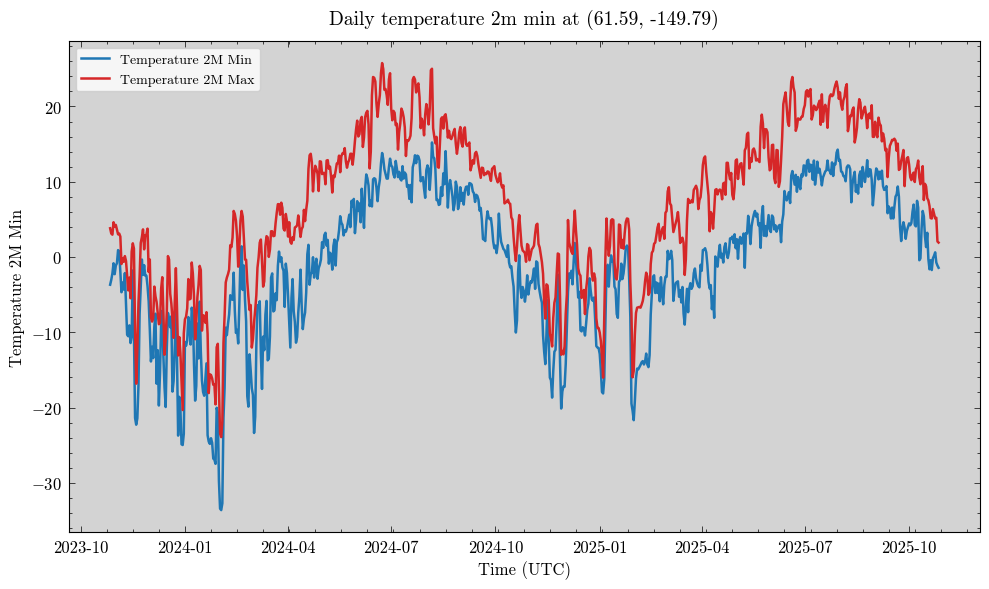

In [132]:


fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")

x = df['date'] 
y = df['temperature_2m_min']
y_2 = df['temperature_2m_max']

ax.plot(
    x, 
    y, 
    color="tab:blue", 
    linewidth=1.8, 
    label=str('temperature_2m_min').replace("_", " ").title()
)

ax.plot(
    x, 
    y_2, 
    color="tab:red", 
    linewidth=1.8, 
    label=str('temperature_2m_max').replace("_", " ").title(),
   
)

ax.set_title(
    f"Daily {'temperature_2m_min'.replace('_', ' ')} at ({LAT:.2f}, {LONG:.2f})",
    fontsize=14,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Time (UTC)", fontsize=12)
ax.set_facecolor("lightgrey")
ax.set_ylabel('temperature_2m_min'.replace("_", " ").title(), fontsize=12)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

In [136]:
adfuller(df['temperature_2m_max'], regression='c')

(np.float64(-2.0481530708860243),
 np.float64(0.26586661985310356),
 9,
 722,
 {'1%': np.float64(-3.439439614524914),
  '5%': np.float64(-2.865551414233055),
  '10%': np.float64(-2.5689061365397747)},
 np.float64(3211.3883030896905))

### Cloud Cover

cloud_cover


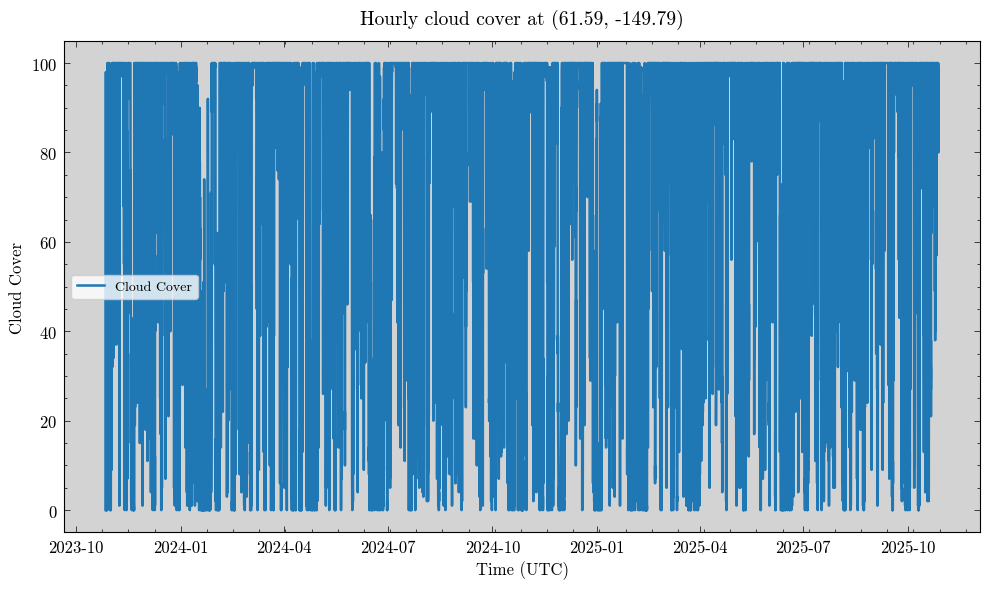

In [ ]:
plot_time_series(LAT, LONG, df, 'cloud_cover')

### Wind Speed

wind_speed_10m


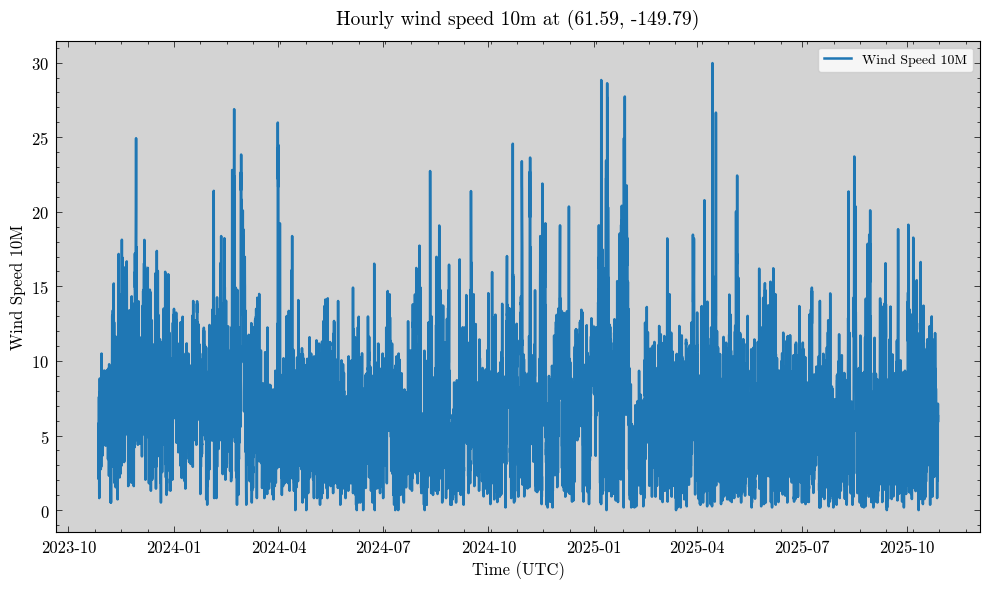

In [ ]:
plot_time_series(LAT, LONG, df, 'wind_speed_10m')

In [ ]:
adfuller(df['wind_speed_10m'] - df['wind_speed_10m'].mean())

(np.float64(-16.333699341201054),
 np.float64(3.043297873912565e-29),
 23,
 17544,
 {'1%': np.float64(-3.4307227916696545),
  '5%': np.float64(-2.861704759545495),
  '10%': np.float64(-2.56685769722479)},
 np.float64(73684.2931811354))